# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(25)

#### Import experiment data 

In [3]:
from DATA import NARMA10

data = NARMA10(True, [80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [4]:
N_UNITS = 150

In [5]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = True)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [6]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [7]:
ip_reservoir.pre_train(X_TR, eta=0.000005, epochs=10,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 2412.675048828125.
- Epoch: 2) | KL Divergence value: 2396.123779296875.
- Epoch: 3) | KL Divergence value: 2379.904296875.
- Epoch: 4) | KL Divergence value: 2363.99658203125.
- Epoch: 5) | KL Divergence value: 2348.384521484375.
- Epoch: 6) | KL Divergence value: 2333.051025390625.
- Epoch: 7) | KL Divergence value: 2317.978271484375.
- Epoch: 8) | KL Divergence value: 2303.151611328125.
- Epoch: 9) | KL Divergence value: 2288.56103515625.
- Epoch: 10) | KL Divergence value: 2274.19384765625.


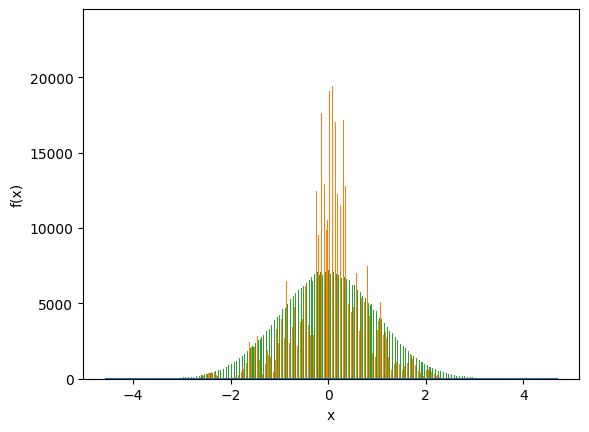

In [8]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [9]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.13870275020599365)  ACTUAL_STD == (0.03162863850593567)][ TARGET_MEAN == (-0.017066866159439087) TARGET_STD == (0.9888566732406616)]
Unit - (2): [ ACTUAL_MEAN == (-1.546168327331543)  ACTUAL_STD == (0.07341120392084122)][ TARGET_MEAN == (0.0032265987247228622) TARGET_STD == (0.9983281493186951)]
Overall network: [ACTUAL_MEAN == (0.04722706973552704)  ACTUAL_STD == (0.7140188813209534)]


## BIMODAL MIXTURE OF GAUSSIAN

In [10]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
#bimodal_reservoir.b_x = b_x
#bimodal_reservoir.b_u = b_u

In [11]:
bimodal_reservoir.pre_train(X_TR, eta= 0.0000015, epochs=15,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3638.615234375.
- Epoch: 2) | KL Divergence value: 3468.44189453125.
- Epoch: 3) | KL Divergence value: 3305.59326171875.
- Epoch: 4) | KL Divergence value: 3150.75439453125.
- Epoch: 5) | KL Divergence value: 3004.454345703125.
- Epoch: 6) | KL Divergence value: 2867.06884765625.
- Epoch: 7) | KL Divergence value: 2738.82568359375.
- Epoch: 8) | KL Divergence value: 2619.82177734375.
- Epoch: 9) | KL Divergence value: 2510.02001953125.
- Epoch: 10) | KL Divergence value: 2409.273681640625.
- Epoch: 11) | KL Divergence value: 2317.362060546875.
- Epoch: 12) | KL Divergence value: 2233.99560546875.
- Epoch: 13) | KL Divergence value: 2158.82177734375.
- Epoch: 14) | KL Divergence value: 2091.454345703125.
- Epoch: 15) | KL Divergence value: 2031.492431640625.


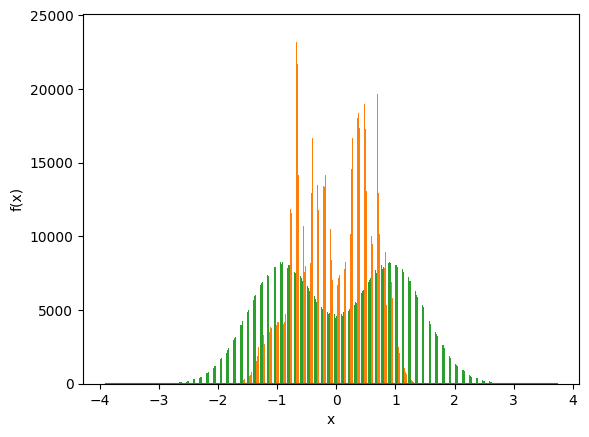

In [12]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [13]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.13445869088172913)  ACTUAL_STD == (0.02869347482919693)][ TARGET_MEAN == (-0.9140366315841675) TARGET_STD == (0.5760928392410278)]
Unit - (2): [ ACTUAL_MEAN == (0.994179368019104)  ACTUAL_STD == (0.08467162400484085)][ TARGET_MEAN == (0.9236140251159668) TARGET_STD == (0.5822049379348755)]
Overall network: [ACTUAL_MEAN == (-0.026752416044473648)  ACTUAL_STD == (0.6063509583473206)]


## EVAUALTUION IN ESN

In [1]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

simple_esn.reservoir.reset_initial_state()
ip_esn.reservoir.reset_initial_state()
bimodal_esn.reservoir.reset_initial_state()

simple_esn.train(X_TR, Y_TR, 0)
ip_esn.train(X_TR, Y_TR, 0)
bimodal_esn.train(X_TR, Y_TR, 0)


ModuleNotFoundError: No module named 'ESN'

### COMPARISON ON TEST DATA

In [15]:
from Metrics import NRMSE, MSE

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.022028915912306133


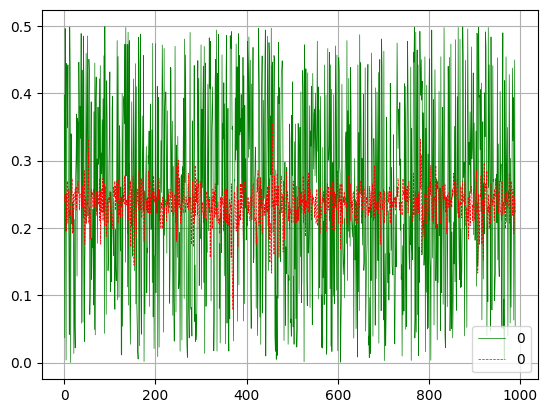

In [16]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.022126887218197073


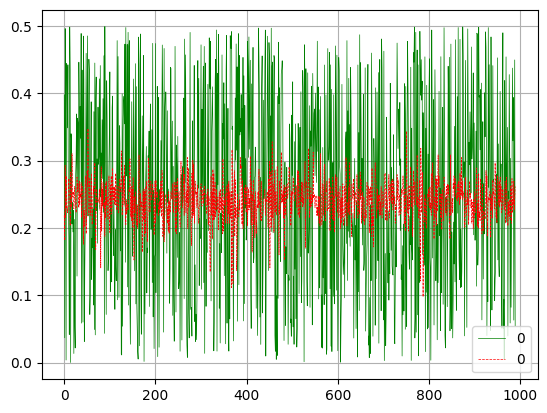

In [17]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.021693860894274254


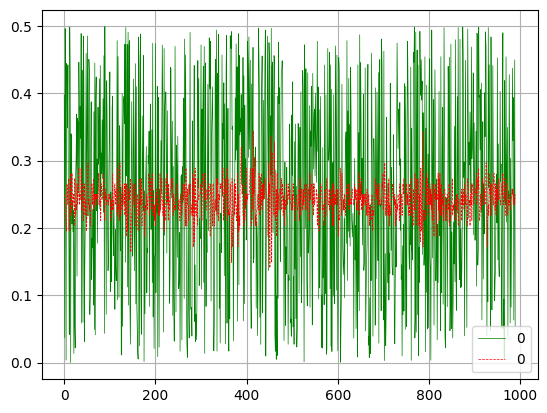

In [18]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

## LYAPUNOV EXPONENTS

In [19]:
simple_esn.reservoir.LCE(X_TS)

-1.4630721

In [20]:
ip_esn.reservoir.LCE(X_TS)

-1.1462189

In [21]:
bimodal_esn.reservoir.LCE(X_TS)

-1.1448984

## MEMORY CAPACITY

In [22]:
def mean_mc(esn: EchoStateNetwork, rep):
    mc = 0
    for _ in range(rep):
        mc += esn.MemoryCapacity()

    return mc/rep

In [23]:
mean_mc(simple_esn, 5)

tensor(7.1207)

In [24]:
mean_mc(ip_esn, 5)

tensor(11.2169)

In [25]:
mean_mc(bimodal_esn, 5)

tensor(11.3975)

## DEVIATION FROM LINEARITY

In [26]:
simple_esn.reservoir.de_fi()

0.12025911745325558

In [27]:
ip_esn.reservoir.de_fi()

0.08498579393935493

In [28]:
bimodal_esn.reservoir.de_fi()

0.05229592050062317